<a href="https://colab.research.google.com/github/kevin6449/ironman2024_genai/blob/main/gen_ai_day18.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 透過嵌入進行異常偵測

In [1]:
import google.generativeai as genai

from google.colab import userdata

API_KEY=userdata.get('GOOGLE_API_KEY')

#genai.configure(api_key="YOUR_API_KEY")

# Configure the client library by providing your API key.
genai.configure(api_key=API_KEY)

#### 設定

In [2]:
import re
import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.datasets import fetch_20newsgroups
from sklearn.manifold import TSNE


列出有支援的嵌入model

In [3]:
for m in genai.list_models():
  if 'embedContent' in m.supported_generation_methods:
    print(m.name)

models/embedding-001
models/text-embedding-004


## 準備資料集

20 Newsgroups Text Dataset 包含 20 個主題的 18,000 個新聞群組貼文，分為訓練和測試集。

In [4]:
newsgroups_train = fetch_20newsgroups(subset='train')

# View list of class names for dataset
newsgroups_train.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

## 訓練集中的範例

In [5]:
idx = newsgroups_train.data[0].index('Lines')
print(newsgroups_train.data[0][idx:])

Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----







### 整理資料

In [6]:
# 應用程式從 newsgroups.data 的資料點中刪除姓名、電子郵件和無關單字

newsgroups_train.data = [re.sub(r'[\w\.-]+@[\w\.-]+', '', d) for d in newsgroups_train.data] # Remove email
newsgroups_train.data = [re.sub(r"\([^()]*\)", "", d) for d in newsgroups_train.data] # Remove names
newsgroups_train.data = [d.replace("From: ", "") for d in newsgroups_train.data] # Remove "From: "
newsgroups_train.data = [d.replace("\nSubject: ", "") for d in newsgroups_train.data] # Remove "\nSubject: "

# 在 5,000 個字元後截斷每個文字條目
newsgroups_train.data = [d[0:5000] if len(d) > 5000 else d for d in newsgroups_train.data]

In [8]:
# 將訓練點放入資料框中
df_train = pd.DataFrame(newsgroups_train.data, columns=['Text'])
df_train['Label'] = newsgroups_train.target
# 將標籤與目標名稱索引相符
df_train['Class Name'] = df_train['Label'].map(newsgroups_train.target_names.__getitem__)

df_train

,Text,Label,Class Name
0,WHAT car is this!?\nNntp-Posting-Host: rac3.w...,7,rec.autos
1,SI Clock Poll - Final Call\nSummary: Final ca...,4,comp.sys.mac.hardware
2,PB questions...\nOrganization: Purdue Univers...,4,comp.sys.mac.hardware
3,Re: Weitek P9000 ?\nOrganization: Harris Comp...,1,comp.graphics
4,Re: Shuttle Launch Question\nOrganization: Sm...,14,sci.space
...,...,...,...
11309,Re: Migraines and scans\nDistribution: world...,13,sci.med
11310,Screen Death: Mac Plus/512\nLines: 22\nOrganiz...,4,comp.sys.mac.hardware
11311,Mounting CPU Cooler in vertical case\nOrganiz...,3,comp.sys.ibm.pc.hardware
11312,Re: Sphere from 4 points?\nOrganization: Cent...,1,comp.graphics


### 在訓練資料集裡取 150 個資料點，然後選擇幾個類別，對部分資料取樣。

In [9]:
# 從 df_train 中抽取每個標籤類別的樣本
SAMPLE_SIZE = 150
df_train = (df_train.groupby('Label', as_index = False)
                    .apply(lambda x: x.sample(SAMPLE_SIZE))
                    .reset_index(drop=True))

# 選擇有關科學的類別
df_train = df_train[df_train['Class Name'].str.contains('sci')]

# 重置索引
df_train = df_train.reset_index()
df_train

,index,Text,Label,Class Name
0,1650,Subject: Re: text of White House announcement ...,11,sci.crypt
1,1651,"Re: Once tapped, your code is no good any mor...",11,sci.crypt
2,1652,Declassifying media\nOrganization: capriccios...,11,sci.crypt
3,1653,Re: The Escrow Database.\nNntp-Posting-Host: ...,11,sci.crypt
4,1654,Crypto Conference\nOrganization: University o...,11,sci.crypt
...,...,...,...,...
595,2245,Re: Questions about Titan IV and Ariane 5\nDi...,14,sci.space
596,2246,Re: Command Loss Timer \nOrganization: Califo...,14,sci.space
597,2247,Re: Life on Mars???\nOrganization: Jet Propul...,14,sci.space
598,2248,Re: Vandalizing the sky.\nOrganization: Lawre...,14,sci.space


In [10]:
df_train['Class Name'].value_counts()

,count
Class Name,
sci.crypt,150
sci.electronics,150
sci.med,150
sci.space,150


## 建立嵌入

將 API 變更為使用模型嵌入功能 001 的嵌入
新的嵌入模型「embedding-001」其中有新的工作類型參數和選用標題 (僅適用於 task_type=RETRIEVAL_DOCUMENT)。

這些新參數僅適用於最新的嵌入模型。工作類型如下：

工作類型	           
 - RETRIEVAL_QUERY:	 指定指定文字是搜尋/擷取設定中的查詢。
 - RETRIEVAL_DOCUMENT:	 指定文字是搜尋/擷取設定中的文件。
 - SEMANTIC_SIMILARITY:	 指定指定文字將用於語意文字相似度 (STS)。
 - 分類:	                指定要將嵌入用於分類。
 - 叢集:	                指定嵌入將用於分群。



In [11]:
from tqdm.auto import tqdm
tqdm.pandas()

from google.api_core import retry

def make_embed_text_fn(model):

  @retry.Retry(timeout=300.0)
  def embed_fn(text: str) -> list[float]:
    # Set the task_type to CLUSTERING.
    embedding = genai.embed_content(model=model,
                                    content=text,
                                    task_type="clustering")['embedding']
    return np.array(embedding)

  return embed_fn

def create_embeddings(df):
  model = 'models/embedding-001'
  df['Embeddings'] = df['Text'].progress_apply(make_embed_text_fn(model))
  return df

df_train = create_embeddings(df_train)
df_train.drop('index', axis=1, inplace=True)

  0%|          | 0/600 [00:00<?, ?it/s]

### 降低維度

文件嵌入向量的維度為 768。為了視覺化呈現內嵌文件的分組方式，您必須套用維度縮減功能，因為您只能在 2D 或 3D 空間中視覺化嵌入嵌入。

In [12]:
len(df_train['Embeddings'][0])

768

In [13]:
# Convert df_train['Embeddings'] Pandas series to a np.array of float32
X = np.array(df_train['Embeddings'].to_list(), dtype=np.float32)
X.shape

(600, 768)

應用 t-DistributedStochastic Neighbor Embedding (t-SNE) 方法來縮減維度。這項技巧可以減少維度數量，同時保留叢集 (相近距離的資料點)。針對原始資料，模型會嘗試建構分佈，並與其他資料點「相鄰」(舉例來說，兩者的意義相近)。接著會最佳化目標函式，在圖表中保持類似的分佈。

In [14]:
tsne = TSNE(random_state=0, n_iter=1000)
tsne_results = tsne.fit_transform(X)

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


In [15]:
df_tsne = pd.DataFrame(tsne_results, columns=['TSNE1', 'TSNE2'])
df_tsne['Class Name'] = df_train['Class Name'] # Add labels column from df_train to df_tsne
df_tsne

,TSNE1,TSNE2,Class Name
0,-13.547009,-33.064537,sci.crypt
1,-19.482790,-22.909454,sci.crypt
2,-15.288780,-20.813129,sci.crypt
3,-22.797033,-29.992130,sci.crypt
4,-6.082082,-26.439976,sci.crypt
...,...,...,...
595,8.812391,-7.050859,sci.space
596,18.822515,-8.508168,sci.space
597,15.169257,-7.008552,sci.space
598,17.772558,3.574435,sci.space


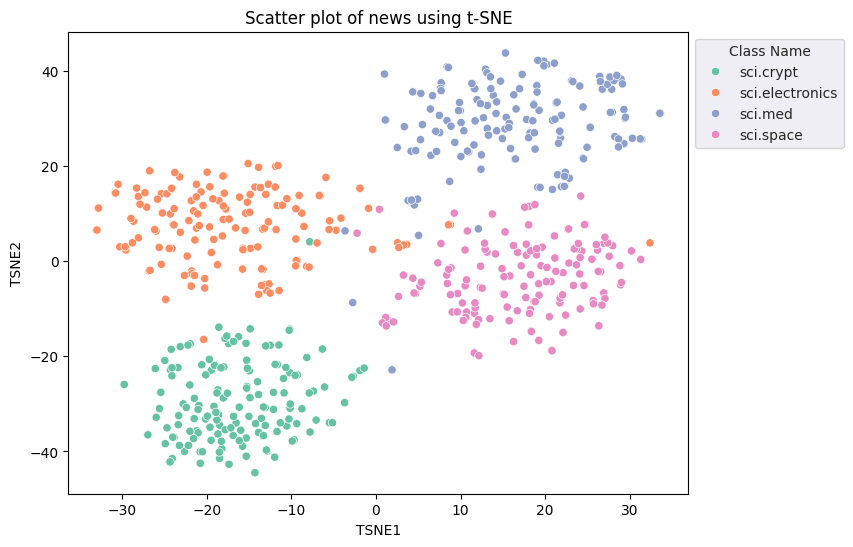

In [16]:
fig, ax = plt.subplots(figsize=(8,6)) # Set figsize
sns.set_style('darkgrid', {"grid.color": ".6", "grid.linestyle": ":"})
sns.scatterplot(data=df_tsne, x='TSNE1', y='TSNE2', hue='Class Name', palette='Set2')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title('Scatter plot of news using t-SNE')
plt.xlabel('TSNE1')
plt.ylabel('TSNE2');

## 離群值偵測

要判斷哪些點異常，請判斷哪些點是離群值和離群值。請先找出代表集群中心的質心或位置，然後使用距離判斷離群值的點。

In [17]:
def get_centroids(df_tsne):
  # Get the centroid of each cluster
  centroids = df_tsne.groupby('Class Name').mean()
  return centroids

centroids = get_centroids(df_tsne)
centroids

,TSNE1,TSNE2
Class Name,,
sci.crypt,-16.389839,-29.267611
sci.electronics,-17.035561,7.392213
sci.med,16.231524,28.787216
sci.space,17.104076,-3.578825


In [18]:
def get_embedding_centroids(df):
  emb_centroids = dict()
  grouped = df.groupby('Class Name')
  for c in grouped.groups:
    sub_df = grouped.get_group(c)
    # Get the centroid value of dimension 768
    emb_centroids[c] = np.mean(sub_df['Embeddings'], axis=0)

  return emb_centroids

In [24]:
emb_c = get_embedding_centroids(df_train)

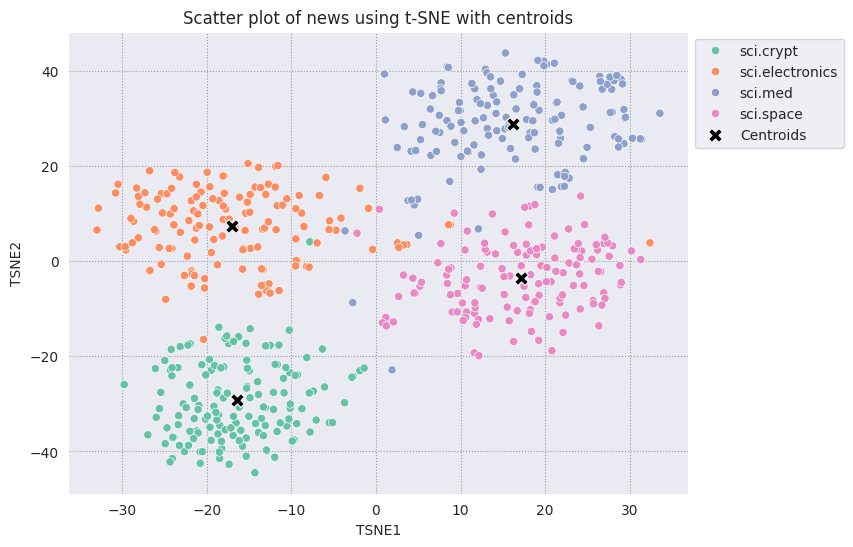

In [19]:
# Plot the centroids against the cluster
fig, ax = plt.subplots(figsize=(8,6)) # Set figsize
sns.set_style('darkgrid', {"grid.color": ".6", "grid.linestyle": ":"})
sns.scatterplot(data=df_tsne, x='TSNE1', y='TSNE2', hue='Class Name', palette='Set2');
sns.scatterplot(data=centroids, x='TSNE1', y='TSNE2', color="black", marker='X', s=100, label='Centroids')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title('Scatter plot of news using t-SNE with centroids')
plt.xlabel('TSNE1')
plt.ylabel('TSNE2');

### 選擇半徑。只要有任何超出該類別質心的值，即視為離群值。

In [22]:
def calculate_euclidean_distance(p1, p2):
  return np.sqrt(np.sum(np.square(p1 - p2)))

def detect_outlier(df, emb_centroids, radius):
  for idx, row in df.iterrows():
    class_name = row['Class Name'] # Get class name of row
    # Compare centroid distances
    dist = calculate_euclidean_distance(row['Embeddings'],
                                        emb_centroids[class_name])
    df.at[idx, 'Outlier'] = dist > radius

  return len(df[df['Outlier'] == True])

In [25]:
range_ = np.arange(0.3, 0.75, 0.02).round(decimals=2).tolist()
num_outliers = []
for i in range_:
  num_outliers.append(detect_outlier(df_train, emb_c, i))

<ipython-input-22-0090db075f78>:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[idx, 'Outlier'] = dist > radius


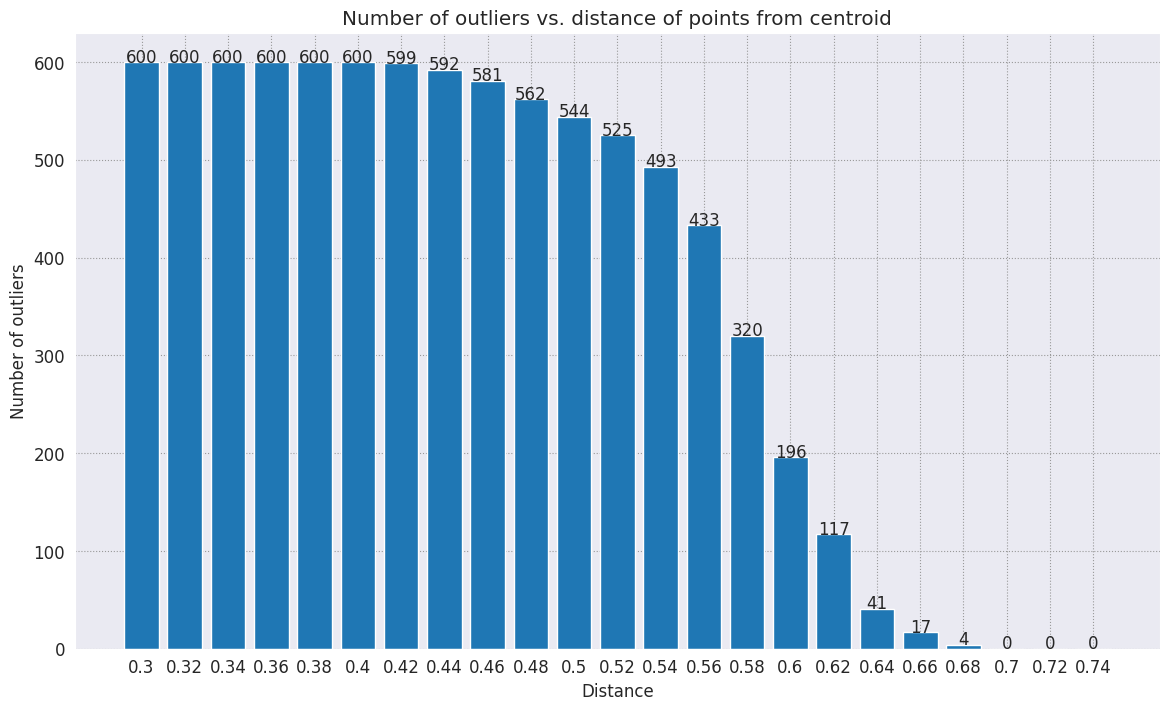

In [26]:
# Plot range_ and num_outliers
fig = plt.figure(figsize = (14, 8))
plt.rcParams.update({'font.size': 12})
plt.bar(list(map(str, range_)), num_outliers)
plt.title("Number of outliers vs. distance of points from centroid")
plt.xlabel("Distance")
plt.ylabel("Number of outliers")
for i in range(len(range_)):
  plt.text(i, num_outliers[i], num_outliers[i], ha = 'center')

plt.show()

根據想要的異常偵測工具的靈敏度，選擇要使用的半徑範圍。目前系統使用的是 0.62，但您可以變更這個值。

In [27]:
# View the points that are outliers
RADIUS = 0.62
detect_outlier(df_train, emb_c, RADIUS)
df_outliers = df_train[df_train['Outlier'] == True]
df_outliers.head()

,Text,Label,Class Name,Embeddings,Outlier
33,Re: Overreacting \nOrganization: Express Acce...,11,sci.crypt,"[-0.014026283, -0.04744478, -0.023989808, -0.0...",True
43,ISSA '93 Conference\nOrganization: Chinet - P...,11,sci.crypt,"[0.04542695, -0.0045831418, -0.026651457, -0.0...",True
55,Re: PEM and MIME\nOrganization: Personal Usen...,11,sci.crypt,"[0.010670439, -0.010967538, -0.05260994, -0.02...",True
56,* REPORT ON PRIVACY-PROTECTING OFF-LINE CASH ...,11,sci.crypt,"[0.0060990495, 0.01995056, -0.08278795, -0.050...",True
61,Re: Trinomial-Based PRNG\nOrganization: Schoo...,11,sci.crypt,"[-0.008872381, -0.06083613, -0.0613925, -0.009...",True


In [28]:
# Use the index to map the outlier points back to the projected TSNE points
outliers_projected = df_tsne.loc[df_outliers['Outlier'].index]

繪製離群值，並以透明的紅色來標示離群值。

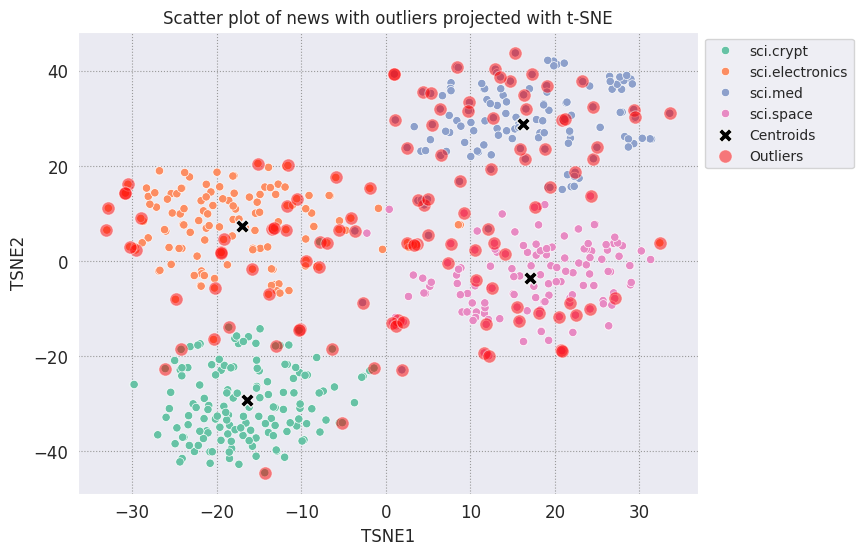

In [29]:
fig, ax = plt.subplots(figsize=(8,6)) # Set figsize
plt.rcParams.update({'font.size': 10})
sns.set_style('darkgrid', {"grid.color": ".6", "grid.linestyle": ":"})
sns.scatterplot(data=df_tsne, x='TSNE1', y='TSNE2', hue='Class Name', palette='Set2');
sns.scatterplot(data=centroids, x='TSNE1', y='TSNE2', color="black", marker='X', s=100, label='Centroids')
# Draw a red circle around the outliers
sns.scatterplot(data=outliers_projected, x='TSNE1', y='TSNE2', color='red', marker='o', alpha=0.5, s=90, label='Outliers')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title('Scatter plot of news with outliers projected with t-SNE')
plt.xlabel('TSNE1')
plt.ylabel('TSNE2');

### 使用 Datafames 的索引值列出幾個各類別離群值可能的示例

In [30]:
sci_crypt_outliers = df_outliers[df_outliers['Class Name'] == 'sci.crypt']
print(sci_crypt_outliers['Text'].iloc[0])

 Re: Overreacting 
Organization: Express Access Online Communications, Greenbelt, MD USA
Lines: 13
Distribution: na
NNTP-Posting-Host: access.digex.net

 > Somebody asked me what was wrong about overreacting in cases such as this.
 >
 > The reason is very simple:  How many people do you want to die in a riot?
 >In a new Civil War?

  Not me -- which is precisely why the government must be cut off at the
knees when it pulls stunts like this, lest the situation worsen to the point
where extreme measures are required.








In [31]:
sci_elec_outliers = df_outliers[df_outliers['Class Name'] == 'sci.electronics']
print(sci_elec_outliers['Text'].iloc[0])

Re: Adcom cheap products?
Organization: Stratus Computer, Marlboro Ma.
Lines: 20
NNTP-Posting-Host: m3-enet.eng.stratus.com


>Off-shore assembly is one reason that Adcom is able to make products 
>that perform as well as those from people like Audio Research and Van 
>Alstine , but at a much lower cost. 

How do you spell "tuna helper" ? 

I gather by off-shore assembly you mean that adcoms are built by 
blue-fin tuna's who are into that squid-fi sound?  . 
My Adcom 555 preamp did sound better after installing the famous  
"running the chips class "A" resistor mod", and replacing the metal 
bottom cover with plexiglass,, too bad the factory could not make em sound 
better,, but better sound, unfortunately, does not appear to be a priority 
with Adcom, else the mods would neither have been necessary, nor would they 
have improved what was already touted as superlative state-o-d-art le'sound. 
I really want to hear from all those people out there who have traded up  
from an sp9II  to a

In [32]:
sci_med_outliers = df_outliers[df_outliers['Class Name'] == 'sci.med']
print(sci_med_outliers['Text'].iloc[0])

 Re: _The Andromeda Strain_
Summary: How well does it hold up?
Organization: Telectronics Pacing Systems
Lines: 43

In article <>   writes:

>Just had the opportunity to watch this flick on A&E -- some 15 years
>since I saw it last.  

Wow, the WWII channel did something not-WWII?

>I was very interested in the technology demonstrated in this film
>for handling infectious diseases .
>Clearly they "faked" a lot of the computer & robotic technology;
>certainly at the time it was made most of that was science fiction
>itself, let alone the idea of a "space germ".  

The graphics capabilities of the computers were very faked for movie 
audiences who have not ability or patience with numbers.  The book was more 
realistic in that respect.  In all respects, actually.  The robotics are 
still out of range, but not impossible.

>Quite coincidentally [actually this is what got me wanted to see
>the movie again] I watched a segment on the otherwise awful _How'd
>They Do That?_ dealing with a dis

In [33]:
sci_space_outliers = df_outliers[df_outliers['Class Name'] == 'sci.space']
print(sci_space_outliers['Text'].iloc[0])

 Re: Sunrise/ sunset times
Nntp-Posting-Host: wren
Organization: Applied Research Labs, University of Texas at Austin
Lines: 13

  writes:


>Hello. I am looking for a program  that can be used
>to compute sunrise and sunset times.

Would you mind posting the responses you get?
I am also interested, and there may be others.

Thanks,

N. Shirlene Pearson


